In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
np.__version__

'1.13.2'

In [3]:
def make_train_tests(DIR="../input/"):
    train=pd.read_csv(DIR+"/stage2_final_train.csv",index_col=0)
    test=pd.read_csv(DIR+"/stage2_final_test.csv",index_col=0)
    labels=train['Class']
    train=train.drop("Class",axis=1)
    print train.min().min(),test.min().min()
    assert (train.columns==test.columns).all()
    train=train.fillna(-999)
    test=test.fillna(-999)
    return (train.values.astype(np.float32),labels.values-1),test.values.astype(np.float32)

In [4]:
(train,labels),test=make_train_tests()
train.shape,labels.shape,test.shape

-6.26036466493 -3.70075827705


((3689, 6500), (3689,), (986, 6500))

In [5]:
train.nbytes/1024*2.,test.nbytes/1024*2.

(187332.0, 50070.0)

In [6]:
pd.Series(labels).value_counts()

6    1054
3     751
0     662
1     498
5     297
4     267
2      96
8      43
7      21
dtype: int64

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold
from sklearn.multiclass import OneVsRestClassifier
import catboost as cat

In [8]:
cat.__version__

'0.2.2'

In [9]:
def shuffle_XY(X,y):
    idx=np.random.permutation(range(len(y)))
    return X[idx],y[idx]
def shuffle_XY2(X,y):
    idx=np.random.choice(range(len(y)),replace=True,size=len(y))
    return X[idx],y[idx]

In [19]:
def make_model(i,trainx,trainy,fold_len_multiplier=2,colsample_bytree=1,max_depth=4, subsample=1,
                    learning_rate=0.03,leaf_estimation_method='Gradient',bagging_temperature=1,
                   border_count=128,random_strength=1,l2_leaf_reg=3 ):
        models=[]
        X,y=shuffle_XY(trainx,trainy)
        kf = KFold(n_splits=5)
        scores=[]
        for train, test in kf.split(X):
            X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
            train_pool=cat.Pool(X_train,y_train)
            valid_pool=cat.Pool(X_test,y_test)
            model=cat.CatBoostClassifier(iterations=2000, learning_rate=learning_rate, 
                                         #eval_metric="MultiClass", 
                                         l2_leaf_reg=l2_leaf_reg,
                                         rsm=colsample_bytree,
                                         fold_len_multiplier=fold_len_multiplier,
                                         leaf_estimation_method=leaf_estimation_method,
                                         border_count=border_count,
                                         bagging_temperature=bagging_temperature,
                                         random_strength=random_strength,
                                         depth=max_depth, 
                                         loss_function='MultiClass',
                                         od_type="Iter",
                                         od_wait=50,
                                         verbose=True)
            model.fit(train_pool,eval_set=valid_pool,use_best_model=True)            
            models.append(model)
            pred=model.predict_proba(X_test)
            scores.append(log_loss(y_test,pred,labels=range(9)))
            print log_loss(y_train,model.predict_proba(X_train),labels=range(9)), scores[-1]
        print scores
        print i, "mean loss", np.mean(scores),np.std(scores)
        #return models
        return np.mean(scores),np.std(scores),models

In [20]:
param={'colsample_bytree': 0.3, 'learning_rate': 0.1, 'random_strength': 1, 'fold_len_multiplier': 2, 'leaf_estimation_method': 'Newton', 'l2_leaf_reg': 3, 'border_count': 32, 'max_depth': 8, 'bagging_temperature': 1}

In [21]:
def run_once(param,train,labels,test):
    colsample_bytree=param["colsample_bytree"]
    max_depth=param["max_depth"]
    learning_rate=param["learning_rate"]
    border_count=param["border_count"]
    l2_leaf_reg=param["l2_leaf_reg"]    
    fold_len_multiplier=param["fold_len_multiplier"]
    leaf_estimation_method=param["leaf_estimation_method"]
    bagging_temperature=param["bagging_temperature"]
    random_strength=param["random_strength"]
    
    scores=[]
    print param
    for i in [-1]:
        s,_,models=make_model(i,train,labels,colsample_bytree=colsample_bytree,
                       max_depth=max_depth,
                       border_count=border_count,
                       learning_rate=learning_rate,
                       l2_leaf_reg=l2_leaf_reg,
                       fold_len_multiplier=fold_len_multiplier,
                       leaf_estimation_method=leaf_estimation_method,
                       bagging_temperature=bagging_temperature,
                       random_strength=random_strength
                      )
        pred=np.mean([m.predict_proba(test) for m in models],axis=0)
        return s,pred

In [22]:
#a=run_once(param,train,labels,test)

In [23]:
import findspark
findspark.init()

In [24]:
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql import SparkSession
conf = SparkConf()
conf.set('spark.executor.cores',1)
conf.set('spark.executor.instances',1) 
conf.set('spark.speculation','true') 
conf.set('spark.driver.memory','40G') 
conf.set('spark.executor.memory','45G') 

#conf.set('spark.cores.max',15)     
conf.setAppName("spark")
conf.setMaster("spark://192.168.0.11:7077")
#conf.setMaster("local")

In [25]:
spark = SparkSession.builder.config(conf=conf).getOrCreate()
sc=spark.sparkContext

In [26]:
data=sc.broadcast((train,labels,test))

In [28]:
N=500
a=sc.parallelize(range(N),N)
a.getNumPartitions()

500

In [ ]:
results=a.map(lambda u: run_once(param,data.value[0],data.value[1],data.value[2])).collect()

In [ ]:
import cPickle as pickle

In [ ]:
pickle.dump((param,results), open('cat_predict_1.pkl','wb'))

In [ ]:
sc.stop()

In [33]:
files=["cat_predict_1.pkl"]

In [34]:
pickled= reduce(lambda u,v: u+v, [pickle.load(open(fname))[1] for fname in files])

In [35]:
len(pickled)

500

In [38]:
u[1][0]

array([ 0.04853339,  0.01002569,  0.00641736,  0.87129674,  0.01398776,
        0.03028104,  0.01031845,  0.0027198 ,  0.00641977])

(0.73931418474897193, 0.0056132988911885154)

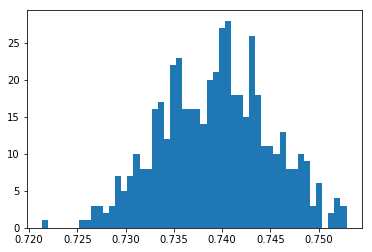

In [37]:
plt.hist([u[0] for u in pickled],bins=50);
np.mean([u[0] for u in pickled]),np.std([u[0] for u in pickled])

(0.86242744255084713, 0.014376838758319624)

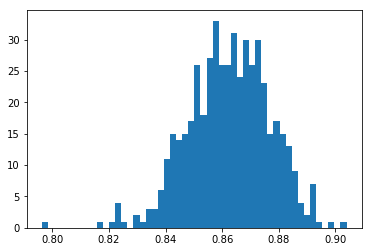

In [39]:
plt.hist([u[1][0][3] for u in pickled],bins=50);
np.mean([u[1][0][3] for u in pickled]),np.std([u[1][0][3] for u in pickled])

(0.050141997530264493, 0.0059776100498376578)

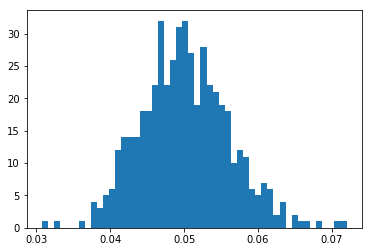

In [40]:
plt.hist([u[1][0][0] for u in pickled],bins=50);
np.mean([u[1][0][0] for u in pickled]),np.std([u[1][0][0] for u in pickled])

In [41]:
mean_preds=np.mean([u[1] for u in pickled],0)

In [42]:
mean_preds.shape

(986, 9)

In [43]:
mean_preds.sum(1).mean()

1.0

In [44]:
test=pd.read_csv("../input/stage2_final_test.csv",index_col=0)

In [45]:
sample_sub=pd.read_csv("../input/stage2_sample_submission.csv",index_col=0)

In [46]:
submission=pd.DataFrame(mean_preds,index=test.index)
submission.columns=sample_sub.columns

In [47]:
submission

class1    class2    class3    class4    class5    class6    class7  \
ID                                                                          
1    0.050142  0.012329  0.007419  0.862427  0.014410  0.029998  0.013886   
2    0.990304  0.001465  0.000240  0.002590  0.000299  0.002515  0.001460   
3    0.036754  0.252936  0.023956  0.242977  0.024649  0.076274  0.325713   
4    0.072142  0.235233  0.006885  0.120698  0.017213  0.086584  0.444598   
5    0.006475  0.236687  0.004339  0.014323  0.011246  0.011595  0.712971   
6    0.081968  0.046541  0.015222  0.137836  0.045869  0.568964  0.076275   
7    0.008163  0.252072  0.003502  0.013808  0.027843  0.006080  0.683934   
8    0.211544  0.117795  0.017036  0.336728  0.042831  0.091097  0.160153   
9    0.261017  0.012313  0.014492  0.653219  0.015510  0.019416  0.018653   
10   0.001899  0.009055  0.191160  0.003039  0.045899  0.002967  0.744325   
11   0.024104  0.130002  0.016540  0.044106  0.063168  0.012409  0.702611   
12   0.001688  0.916222  0.001462  0.002442  0.003889  0.002428  0.069762   
13   0.955679  0.000824  0.002000  0.008074  0.024799  0.006311  0.001277   
14   0.002048  0.035491  0.006797  0.003415  0.006237  0.002878  0.941807   
15   0.039228  0.402758  0.011145  0.067159  0.041623  0.150362  0.231143   
16   0.767928  0.119064  0.002380  0.058458  0.011822  0.014757  0.013501   
17   0.097932  0.242745  0.004970  0.097512  0.029502  0.047309  0.456368   
18   0.081601  0.191159  0.025178  0.171923  0.043372  0.048792  0.424571   
19   0.021320  0.148280  0.007083  0.022760  0.066531  0.014272  0.711541   
20   0.048719  0.491921  0.008890  0.086213  0.026929  0.097426  0.226538   
21   0.002421  0.038075  0.002877  0.003914  0.006370  0.002351  0.941173   
22   0.010864  0.007221  0.010007  0.929816  0.007696  0.006262  0.007914   
23   0.543809  0.048031  0.019251  0.099705  0.074440  0.039860  0.152464   
24   0.001180  0.297163  0.000561  0.002242  0.001378  0.001887  0.689568   
25   0.173776  0.034812  0.025099  0.625957  0.029495  0.036111  0.064228   
26   0.001721  0.012886  0.006959  0.001986  0.007754  0.002797  0.964347   
27   0.049531  0.329056  0.009544  0.246736  0.015391  0.021530  0.314834   
28   0.030505  0.482132  0.011593  0.063603  0.031157  0.012418  0.355834   
29   0.038310  0.333344  0.010948  0.425232  0.019146  0.023849  0.140219   
30   0.068077  0.639608  0.005499  0.073090  0.027415  0.052463  0.126434   
..        ...       ...       ...       ...       ...       ...       ...   
957  0.008316  0.002612  0.016845  0.960792  0.004210  0.003865  0.002738   
958  0.005259  0.124191  0.010661  0.010276  0.043411  0.005222  0.797804   
959  0.953934  0.002153  0.002539  0.020152  0.009755  0.005584  0.003889   
960  0.295714  0.035374  0.015068  0.383568  0.050897  0.035941  0.168828   
961  0.099949  0.132229  0.018539  0.175566  0.046076  0.042898  0.472604   
962  0.000286  0.013718  0.000715  0.000583  0.000650  0.000511  0.983177   
963  0.936824  0.002474  0.000440  0.048147  0.000757  0.002865  0.005780   
964  0.178078  0.413476  0.018407  0.036375  0.064742  0.018797  0.255452   
965  0.016236  0.832361  0.004522  0.019826  0.018649  0.021396  0.078562   
966  0.050983  0.205280  0.014737  0.094544  0.044249  0.159696  0.343964   
967  0.194231  0.000452  0.002735  0.795272  0.003313  0.002614  0.000535   
968  0.007443  0.724020  0.002248  0.005704  0.015678  0.005766  0.236332   
969  0.805552  0.004569  0.005134  0.150354  0.016263  0.008595  0.006511   
970  0.108548  0.276374  0.010916  0.035557  0.043951  0.012068  0.500612   
971  0.788578  0.116535  0.002114  0.047632  0.008985  0.012700  0.011291   
972  0.495293  0.048872  0.004629  0.337856  0.012342  0.036946  0.053018   
973  0.794388  0.107846  0.003014  0.041400  0.013786  0.015507  0.013391   
974  0.008245  0.095944  0.014101  0.019038  0.032041  0.008230  0.814424   
975  0.054823  0.269096  0.016594  0.149216  0.028066  0.056956  0.410288   
976

In [48]:
submission.sum(1).mean()

1.0

In [49]:
submission.to_csv("../input/sub_cat.csv")